# Exercise 3.2
Download Cell Towers data about France from OpenCellID. Then,
create and visualize (in folium) a Voronoi tessellation of GSM towers
in Lyon, France. Repeat for another French city.
* Use the geovoronoi package to create the Voronoi tessellation
* Plot the tessellation with folium
* (Use just a random sample if the towers if they are too many
to be visualized and/or to compute the tessellation)
* Submit a (well commented) python notebook

## Installing the libraries

In [ ]:
# correct order to avoid errors
!pip install Shapely
!pip install folium
!pip install Fiona
!pip install pyproj
!pip install rtree
!pip install pygeos
!pip install scikit-mobility
!pip install -U geopandas #scikit mobilty force the installation of geopandas 0.9 for compatibiltiy but that version doesn't have some features as "sjoin" from geopandas
!pip install geovoronoi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 16.7 MB 426 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.3 MB 8.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 8.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.1 MB 6.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 154 kB 7.3 MB/s 
     |███████████████

## Importing the libraries

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import numpy as np

import skmob
import folium
import random

#to tessellate and plot tessellations
from skmob.tessellation.tilers import tiler
from skmob.utils.plot import plot_gdf

#for the Voronoi Tessellation
from scipy.spatial import Voronoi,voronoi_plot_2d
from geovoronoi import voronoi_regions_from_coords, points_to_coords
from shapely.geometry import *

#to unzip the files
import zipfile

## Importing functions useful to compute the Voronoi Tessellation

In [ ]:
############## Series of Functions to plot a Voronoi Tessellation ##############
#get the convex hull from the squared tessellation to create the border of the space
def get_convex_hull(tess):
    polygon = tess.at[0, 'geometry']
    for tile in tess['geometry']:
        polygon = polygon.union(tile)
    return polygon.convex_hull

#creating the GeoDataFrame with the geometry of the tessellation
def to_GeoDataFrame(region_polys):
    tile_id=[]
    for i in range(len(region_polys)):
        tile_id.append(i)
    gdf = gpd.GeoDataFrame(columns=['tile_ID','geometry'], crs='epsg:4326')
    gdf['tile_ID'] = tile_id
    for index, row in gdf.iterrows():
        gdf.at[index, 'geometry'] = region_polys[index]
    return gdf

#main to create a voronoi tessellation
def get_voronoi_tessellation(tess, point_geom):
    poly_ch = get_convex_hull(tess) #I did it so that I could input only the tessellation
    coords = np.array(list(zip(point_geom.x, point_geom.y)))  #I adjusted the code to use a geometry of a gdf instead of points
    vor = Voronoi(coords, qhull_options='Qbb Qc Qx')
    region_polys, region_pts = voronoi_regions_from_coords(point_geom, poly_ch)
    tess_voronoi = to_GeoDataFrame(region_polys)
    return tess_voronoi

## Loading the file

In [ ]:
file_path = '/content/drive/MyDrive/FranceCells/208.csv.gz'
df = pd.read_csv(file_path, header = None) #it didn't have a header, only data
print('{:,} Records'.format(len(df)))
df.head() #showing the dataframe

2,084,070 Records


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,UMTS,208,10,18013,8653445,0,2.272110,48.980484,1000,3,1,1290000321,1290000321,0
1,UMTS,208,10,16505,47046446,0,2.540156,50.485447,1000,151,1,1290033687,1406341488,0
2,GSM,208,20,80,17939,0,-1.229193,49.292793,8732,63,1,1290277096,1290465250,0
3,GSM,208,20,80,18060,0,-1.214537,49.290525,10858,77,1,1290277096,1290464523,0
4,UMTS,208,1,29191,26486747,0,7.172216,43.753281,1342,27,1,1290406958,1290406958,0


## Excluding cells that are not GSM

In [ ]:
print(df[0].unique())

['UMTS' 'GSM' 'LTE' 'NR' 'CDMA']


In [ ]:
df = df[df[0] == 'GSM'].reset_index(drop=True) #reassigning the dataframe to the one with only GSM cells
print('{:,} Records'.format(len(df)))
df.head()

490,616 Records


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,GSM,208,20,80,17939,0,-1.229193,49.292793,8732,63,1,1290277096,1290465250,0
1,GSM,208,20,80,18060,0,-1.214537,49.290525,10858,77,1,1290277096,1290464523,0
2,GSM,208,1,29188,3403,0,7.191202,43.709568,2297,200,1,1290426771,1662955409,0
3,GSM,208,1,29188,3516,0,7.186196,43.730374,707,104,1,1290426771,1664186668,0
4,GSM,208,1,29185,29308,0,7.204447,43.762039,9127,1998,1,1290426771,1519122677,0


In [ ]:
#creating a GeoDF with the geometry column generated from latitude and longitude
geometry_col = gpd.points_from_xy(df[6], df[7]) #df[6] is the longitude, df[7] the latitude (the first point is in France, so it's correct)
gdf = gpd.GeoDataFrame(df, geometry=geometry_col, crs='epsg:4326') #creating the actual gdf
gdf.head() #showing to be sure it got created

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,geometry
0,GSM,208,20,80,17939,0,-1.229193,49.292793,8732,63,1,1290277096,1290465250,0,POINT (-1.22919 49.29279)
1,GSM,208,20,80,18060,0,-1.214537,49.290525,10858,77,1,1290277096,1290464523,0,POINT (-1.21454 49.29053)
2,GSM,208,1,29188,3403,0,7.191202,43.709568,2297,200,1,1290426771,1662955409,0,POINT (7.19120 43.70957)
3,GSM,208,1,29188,3516,0,7.186196,43.730374,707,104,1,1290426771,1664186668,0,POINT (7.18620 43.73037)
4,GSM,208,1,29185,29308,0,7.204447,43.762039,9127,1998,1,1290426771,1519122677,0,POINT (7.20445 43.76204)


## Creating a Squared Tessellation over Lyon

In [ ]:
#creating a squared tassellation for Lyon, each square 500 meters each
tess_squared = tiler.get('squared', base_shape='Lyon, France', meters=500)
print(f"tiles = {len(tess_squared)}")
tess_squared.head()

tiles = 475


,tile_ID,geometry
0,0,"POLYGON ((4.77181 45.74499, 4.77181 45.74813, ..."
1,1,"POLYGON ((4.77181 45.74813, 4.77181 45.75126, ..."
2,2,"POLYGON ((4.77181 45.75126, 4.77181 45.75440, ..."
3,3,"POLYGON ((4.77630 45.74499, 4.77630 45.74813, ..."
4,4,"POLYGON ((4.77630 45.74813, 4.77630 45.75126, ..."


## Spatial Join between the GMS cells locations and the Squared Tessellation

In [ ]:
lyon_cells = gpd.sjoin(gdf, tess_squared)
print(f'Number of Lyon GSM cells = {len(lyon_cells)}')
lyon_cells.head()

Number of Lyon GSM cells = 4403


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,geometry,index_right,tile_ID
1167,GSM,208,1,1795,25967,0,4.831499,45.709714,1795,103,1,1310453372,1664180063,0,POINT (4.83150 45.70971),209,209
57293,GSM,208,20,14,36571,0,4.834056,45.708920,5243,91,1,1334656280,1526133587,0,POINT (4.83406 45.70892),209,209
57319,GSM,208,1,1795,17491,0,4.833775,45.709548,3613,894,1,1334659973,1657546867,0,POINT (4.83378 45.70955),209,209
109928,GSM,208,20,14,4040,0,4.833070,45.710335,1906,12,1,1361291326,1406013609,0,POINT (4.83307 45.71034),209,209
185908,GSM,208,20,243,45918,0,4.831241,45.708758,2964,26,1,1455030111,1514769177,0,POINT (4.83124 45.70876),209,209


## Drawing the Convex Hull of the Squared Tessellation

In [ ]:
poly_ch = get_convex_hull(tess_squared)
gdf_convexhull = gpd.GeoDataFrame(geometry=[poly_ch], crs = 'epsg:4326')

## Plotting the Cells, the Convex Hull and the Tessellation
I had to delete the output to reduce the size of the notebook

In [ ]:
tess_map = plot_gdf(tess_squared, zoom=13)
plot_gdf(gdf_convexhull, map_f = tess_map)
plot_gdf(lyon_cells, map_f = tess_map)

## Redoing the Squared Tessellation and the Spatial Join
I could avoid showing the previous step but I preferred leaving the for the sake of the clarity of my thought process.</br>
I decided to redo the Squared Tessellation on the area covered by the Convex Hull to avoid assigning points to areas covered by GSM cells external to Lyon.

In [ ]:
#creating a squared tassellation for Lyon, each square 500 meters each
tess_squared = tiler.get('squared', base_shape=gdf_convexhull, meters=500)
print(f"tiles = {len(tess_squared)}")

#spatial join between the new squared tessellation of the convex hull
lyon_cells = gpd.sjoin(gdf, tess_squared)
print(f'Number of Lyon GSM cells = {len(lyon_cells)}')
lyon_cells.head()

/usr/local/lib/python3.7/dist-packages/skmob/tessellation/tilers.py:117: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  base_shape = gpd.GeoSeries(cascaded_union(polygons), crs=base_shape.crs)


tiles = 707
Number of Lyon GSM cells = 5456


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,geometry,index_right,tile_ID
1167,GSM,208,1,1795,25967,0,4.831499,45.709714,1795,103,1,1310453372,1664180063,0,POINT (4.83150 45.70971),317,317
57293,GSM,208,20,14,36571,0,4.834056,45.708920,5243,91,1,1334656280,1526133587,0,POINT (4.83406 45.70892),317,317
57319,GSM,208,1,1795,17491,0,4.833775,45.709548,3613,894,1,1334659973,1657546867,0,POINT (4.83378 45.70955),317,317
109928,GSM,208,20,14,4040,0,4.833070,45.710335,1906,12,1,1361291326,1406013609,0,POINT (4.83307 45.71034),317,317
185908,GSM,208,20,243,45918,0,4.831241,45.708758,2964,26,1,1455030111,1514769177,0,POINT (4.83124 45.70876),317,317


## Getting the Voronoi Tessellation

In [ ]:
tess_voronoi = get_voronoi_tessellation(tess_squared, lyon_cells['geometry'].values)
tess_voronoi.head()

,tile_ID,geometry
0,0,"POLYGON ((4.80358 45.79730, 4.80652 45.79708, ..."
1,1,"POLYGON ((4.80309 45.80382, 4.80286 45.80435, ..."
2,2,"POLYGON ((4.90131 45.73834, 4.90036 45.74033, ..."
3,3,"POLYGON ((4.89870 45.73377, 4.89808 45.73561, ..."
4,4,"POLYGON ((4.77996 45.74009, 4.78523 45.73687, ..."


## Result on Lyon

In [ ]:
voronoi_map = plot_gdf(tess_voronoi, zoom=12)
plot_gdf(lyon_cells, map_f=voronoi_map)

In order to show the results without having a too heavy notebook I decided to include a screenshot in the markdown hereunder, so that the notebook doesn't have to store all the info about all the geometries:

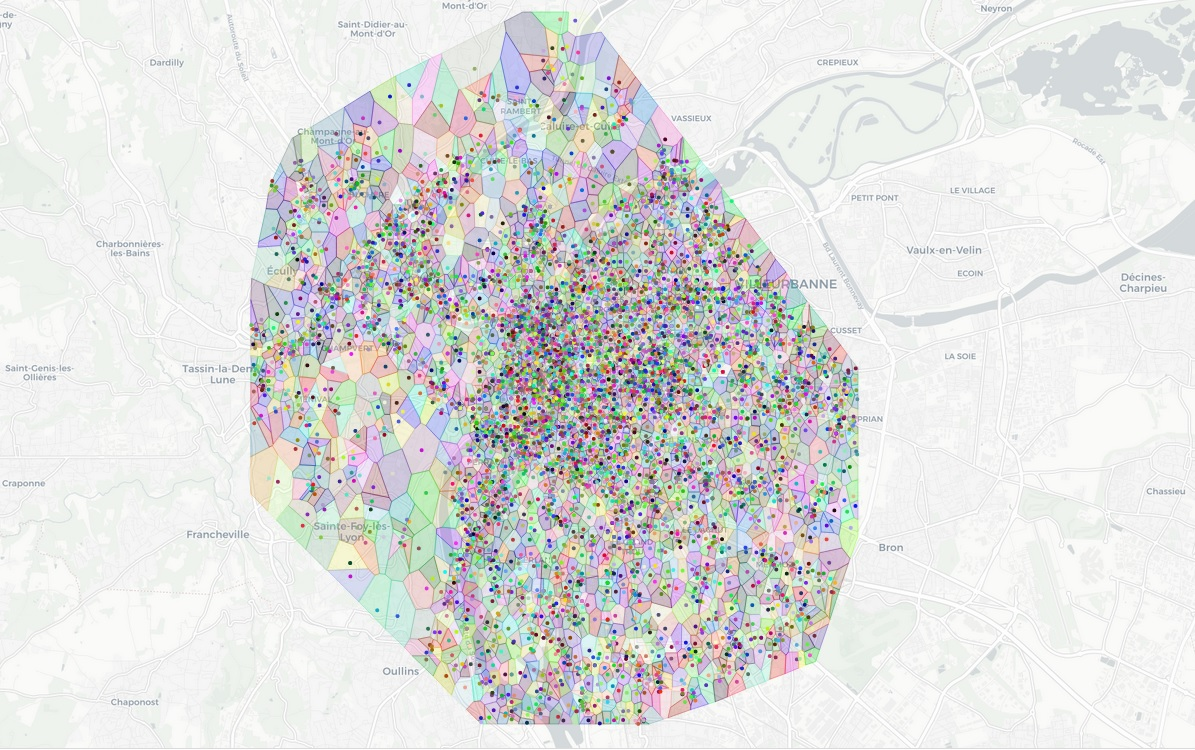

## Writing a class to repeat the process again

In [ ]:
class Voronoi_GSM():
    #setting the constructor
    def __init__(self, geoDataFrame, city = 'Lyon, France', border_precision=500):
        ### Getting the squared tessellation
        basic_tessellation = tiler.get('squared', base_shape=city, meters=border_precision) #get basic borders of the city
        poly_ch = get_convex_hull(basic_tessellation) #get the convex hull of the border of the city
        gdf_convexhull = gpd.GeoDataFrame(geometry=[poly_ch], crs = 'epsg:4326') #creating a gdf of the convex hull

        #doing a spatial join between the gsm towers and the convex hull to leave only towers inside the area
        self.cell_after_sjoin = gpd.sjoin(geoDataFrame, gdf_convexhull)
        
        #getting the coordinates of the points of the GSM cells
        geom = self.cell_after_sjoin['geometry']
        coords = np.array(list(zip(geom.x, geom.y)))

        #performing the Voronoi tessellation
        vor = Voronoi(coords, qhull_options='Qbb Qc Qx')
        region_polys, region_pts = voronoi_regions_from_coords(geom, poly_ch)
        self.tess_voronoi = to_GeoDataFrame(region_polys)

    #adding a method to directly plot the result as before
    def plot(self):
        voronoi_map = plot_gdf(self.tess_voronoi, zoom=12)
        return plot_gdf(self.cell_after_sjoin, map_f=voronoi_map)

## Trying on some other cities: (it works!)
I deleted the output as the size of the notebook would exaggerated


In [ ]:
Voronoi_GSM(gdf, city = 'Lille, France', border_precision=500).plot()

In [ ]:
Voronoi_GSM(gdf, city = 'Nice, France', border_precision=500).plot()

In [ ]:
Voronoi_GSM(gdf, city = 'Marseille, France', border_precision=500).plot()